# Imports

In [1]:
# !jupyter kernelspec uninstall w210_env --y

# https://medium.com/@nrk25693/how-to-add-your-conda-environment-to-your-jupyter-notebook-in-just-4-steps-abeab8b8d084

In [2]:
pwd

'/home/ec2-user/SageMaker/teledermatologyAI_capstone/notebooks/modelling'

In [3]:
cd /home/ec2-user/SageMaker/teledermatologyAI_capstone

/home/ec2-user/SageMaker/teledermatologyAI_capstone


In [4]:
# create new virtual env
# !python -m venv w210_env

In [5]:
# run this for every instance spin up
# !source w210_env/bin/activate && ipython kernel install --user --name w210_env

In [6]:
# run this if added new packages
# !./w210_env/bin/pip install -r requirements.txt

In [7]:
# %pip install -r requirements.txt
# !pip uninstall sklearn --y

In [8]:
# import sys
# print(sys.prefix)
# !which pip
# !./w210_env/bin/pip show scikit-learn

In [9]:
import os
import glob
import shutil
import time
import copy
import random
import itertools
from datetime import datetime
from pytz import timezone

import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mp_image
import seaborn as sns

from IPython.display import Image, display

from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models

import torch
from torch.utils.data import DataLoader
from torch.utils.mobile_optimizer import optimize_for_mobile
import torch.nn as nn

from torch_lr_finder import LRFinder

from sklearn.metrics import confusion_matrix, f1_score

import awswrangler as wr

from pytorchtools import EarlyStopping

# expand pandas df rows/column widths etc.
pd.set_option("display.max_rows", None, # display all rows
              "display.max_columns", None, # display all columns
              "display.max_colwidth", None, # expand column width
              "display.html.use_mathjax", False
             ) # disable Latex style mathjax rendering

In [10]:
# credits: https://github.com/yuliyabohdan/Skin-diseases-classification-Dermnet-/blob/main/skin_diseases_clas_ResNet50.ipynb
data_split = 'split_8'
data_dir = 'data_class_folder8'

DIR = data_dir
DIR_TRAIN = f'{DIR}/train/'
DIR_VAL = f'{DIR}/val/'
DIR_TEST = f'{DIR}/test/' 

classes = sorted(os.listdir(DIR_TRAIN))
print(f'Data split: {DIR}')
print(f'Total classes: {len(classes)}')

# total train, val and test images
train_count = 0
val_count = 0
test_count = 0

classes_df = []
for _class in classes:
    class_dict = {}
    train_count += len(os.listdir(DIR_TRAIN + _class))
    val_count += len(os.listdir(DIR_VAL + _class))
    test_count += len(os.listdir(DIR_TEST + _class))
    class_dict.update({'Class': _class, 
                       'Train': len(os.listdir(DIR_TRAIN + _class)),
                       'Val': len(os.listdir(DIR_VAL + _class)),
                       'Test': len(os.listdir(DIR_TEST + _class)) })
    classes_df.append(class_dict)

print(f'Total num train images: {train_count}')
print(f'Total num val images: {val_count}')
print(f'Total num test images: {test_count}')
print(pd.DataFrame(classes_df))

Data split: data_class_folder8
Total classes: 5
Total num train images: 18072
Total num val images: 3576
Total num test images: 2418
                                                Class  Train  Val  Test
0                              Benign Marking or Mole   3616  721   486
1                        Non-Cancerous Skin Condition   3610  696   495
2                   Potentially Malignant Skin Tumors   3622  724   456
3  Toxin, Fungal, Bug, Viral, or Bacterial Infections   3660  722   458
4                                        Unclassified   3564  713   523


# Modeling

In [11]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            
def initialize_model(model_name, num_classes, feature_extract=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet50
        """
        model_ft = models.resnet50(weights='DEFAULT')
        #we can select any possible variation of ResNet such as Resnet18, Resnet34, Resnet50, Resnet101, and Resnet152
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes) 
        input_size = 224

    elif model_name == "inception":
        """ Inception v3 
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299
        
    elif model_name == "mobilenetv2":
        model_ft = models.mobilenet_v2(weights='DEFAULT')
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier = nn.Linear(1280, num_classes) 
        input_size = 224

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

In [12]:
# https://stackoverflow.com/questions/67959327/how-to-calculate-the-f1-score
def train_model(model, dataloaders, criterion, optimizer, num_epochs, patience):
    since = time.time()

    val_acc_history = []
    val_loss_history = []
    train_acc_history = []
    train_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)


    for epoch in range(num_epochs):
        print('\nEpoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:               
                model.eval()   # Set model to evaluate mode
                #update_bn_stats(model=model, data_loader=dataloaders[phase])  # if update_bn_stats
                
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                      # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
#                 f1score = f1_score(labels.cpu().data, preds.cpu(), average='macro')

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
                
#                 # early_stopping needs the validation loss to check if it has decresed, 
#                 # and if it has, it will make a checkpoint of the current model
#                 early_stopping(epoch_loss, model)
#                 if early_stopping.early_stop:
#                     best_acc = epoch_acc
#                     best_model_wts = copy.deepcopy(model.state_dict())
#                     print("Early stopping")
#                     break     
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
        
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
   
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [13]:
def test_model(model, dl, normalize=True):
    model.eval()
    true_labels = []
    predictions = []
    total = 0
    num_correct = 0
    with torch.no_grad():
        for images, labels in dl:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predicted = torch.argmax(outputs.data,-1)        
            true_labels.append(labels.cpu().numpy())
            predictions.append(predicted.cpu().numpy())
            total += labels.size(0)
            num_correct += (predicted == labels).sum()
        print(f'Test Accuracy of the model: {float(num_correct)/float(total)*100:.2f}')    
        true_labels = np.hstack(true_labels)
        predictions = np.hstack(predictions)

    return true_labels, predictions

In [14]:
# x, y - find the img from class x labelled as class y 
def test(model, dl, x, y, normalize=True):
    model.eval()
    true_labels = []
    predictions = []
    images_list = []

    with torch.no_grad():
        for images, labels in dl:
            images_list.append(images.cpu().numpy())
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predicted = torch.argmax(outputs.data,-1)        
            true_labels.append(labels.cpu().numpy())
            predictions.append(predicted.cpu().numpy())
    
    for n in range(60):
        for i in range(32):
            if (true_labels[n][i] == x)  & (predictions[n][i] == y):
                #inv_tensor = inv_normalize(image_list[n][i]])
                plt.imshow(np.transpose(images_list[n][i], (1, 2, 0)))
                plt.show()

# Grid Search

In [19]:
epochs_list = [10]
learning_rate_list = [0.00056]
batch_size_list = [64]
optimizer_list = [
#     'Adam', 
    'AdamW', 
#     'SGD'
]

model_list = [
#     'mobilenetv2',
#     'densenet',
    'resnet'
]

grid_list = [
    epochs_list,
    learning_rate_list,
    batch_size_list,
    optimizer_list,
    model_list
            ]

grid = list(itertools.product(*grid_list))
random.shuffle(grid)

In [20]:
norm_mean = (0.52282846, 0.40116197, 0.3771196) #(0.485, 0.456, 0.406)
norm_std = (0.26569337, 0.22866993, 0.23022729) #(0.229, 0.224, 0.225)
num_workers = 16
feature_extract=True
num_loop = 1

results_df = pd.DataFrame(columns=[
    'dataset',
    'num_classes',
    'model',
    'val_accuracy',
    'train_time (min)',
    'epochs',
    'learning_rate',
    'optimizer',
    'batch_size',
])

for i in range(num_loop):
    print(f'''
  {i+1}. epochs={grid[i][0]} 
     learning_rate={grid[i][1]} 
     batch_size={grid[i][2]} 
     optimizer={grid[i][3]}
     model={grid[i][4]}
        ''') 
    start_time = time.time()#datetime.now(timezone('America/Chicago')).strftime('%Y%m%d-%H%M%S')
    model_ft, input_size = initialize_model(model_name=grid[i][4], num_classes=len(classes), 
                                            feature_extract=feature_extract)
    
    train_dataset =ImageFolder(root = DIR_TRAIN, transform=transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(20),
        transforms.RandomCrop(size=(input_size, input_size)),
        transforms.ToTensor(), transforms.Normalize(norm_mean, norm_std)]))

    valid_dataset = ImageFolder(root = DIR_VAL, transform=transforms.Compose([
        transforms.Resize((input_size, input_size)), 
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std)]))

    test_dataset = ImageFolder(root = DIR_TEST, transform=transforms.Compose([
        transforms.Resize((input_size,input_size)), 
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std)]))
    
    dataloaders_dict = {}
    dataloaders_dict['train'] = DataLoader(train_dataset, batch_size=grid[i][2], 
                                           shuffle=True, num_workers=num_workers)
    dataloaders_dict['val'] = DataLoader(valid_dataset, batch_size=grid[i][2], 
                                         shuffle=False, num_workers=num_workers, drop_last=False)
    dataloader_test = DataLoader(test_dataset, batch_size=grid[i][2], shuffle=False, 
                                 num_workers=num_workers, drop_last=False)
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model_ft = model_ft.to(device)
    
    # Gather the parameters to be optimized/updated in this run. If we are
    #  fine tuning we will be updating all parameters. However, if we are 
    #  doing feature extract method, we will only update the parameters
    #  that we have just initialized, i.e. the parameters with requires_grad
    #  is True.
    params_to_update = model_ft.parameters()
    print("Params to learn:")
    if feature_extract:
        params_to_update = []
        for name,param in model_ft.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)
                print("\t",name)
    else:
        for name,param in model_ft.named_parameters():
            if param.requires_grad == True:
                print("\t",name)
                             
    optimizer_ft = getattr(torch.optim, grid[i][3])(model_ft.parameters(), lr=grid[i][1])
    criterion = nn.CrossEntropyLoss()
    
    model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, 
                                 num_epochs=grid[i][0], patience=3)
    
    end_time = time.time() - start_time
    
    row = {
        'dataset': data_split,
        'num_classes': int(len(classes)),
        'model': grid[i][4],
        'val_accuracy': f'{hist[0].item():.2f}',
        'train_time (min)': f'{end_time/60:.0f}',
        'epochs': int(grid[i][0]),
        'learning_rate': grid[i][1],
        'optimizer': grid[i][3],
        'batch_size': int(grid[i][2])
    }
    
    new_df = pd.DataFrame([row])
    results_df = pd.concat([results_df, new_df], axis=0, ignore_index=True).sort_values('val_accuracy', ascending = False)

results_df


  1. epochs=10 
     learning_rate=0.00056 
     batch_size=64 
     optimizer=AdamW
     model=resnet
        
Params to learn:
	 fc.weight
	 fc.bias

Epoch 0/9
----------
train Loss: 1.0190 Acc: 0.6099
val Loss: 0.8583 Acc: 0.6641


Epoch 1/9
----------
train Loss: 0.8461 Acc: 0.6712
val Loss: 0.7965 Acc: 0.6798


Epoch 2/9
----------
train Loss: 0.8041 Acc: 0.6868
val Loss: 0.7726 Acc: 0.6952


Epoch 3/9
----------
train Loss: 0.7789 Acc: 0.6974
val Loss: 0.7534 Acc: 0.7053


Epoch 4/9
----------
train Loss: 0.7721 Acc: 0.6954
val Loss: 0.7462 Acc: 0.7013


Epoch 5/9
----------
train Loss: 0.7528 Acc: 0.7058
val Loss: 0.7416 Acc: 0.7089


Epoch 6/9
----------
train Loss: 0.7494 Acc: 0.7070
val Loss: 0.7280 Acc: 0.7142


Epoch 7/9
----------
train Loss: 0.7374 Acc: 0.7126
val Loss: 0.7317 Acc: 0.7136


Epoch 8/9
----------
train Loss: 0.7308 Acc: 0.7169
val Loss: 0.7219 Acc: 0.7100


Epoch 9/9
----------
train Loss: 0.7315 Acc: 0.7153
val Loss: 0.7208 Acc: 0.7122

Training complete 

,dataset,num_classes,model,val_accuracy,train_time (min),epochs,learning_rate,optimizer,batch_size
0,split_8,5,resnet,0.66,13,10,0.00056,AdamW,64


In [21]:
model_name = f'{data_split}_resnet_10e_AdamW_lr0_00056'
torch.save(model_ft, f'model/{model_name}.pt')

In [22]:
model = torch.load(f'model/{model_name}.pt')

Test Accuracy of the model: 70.02


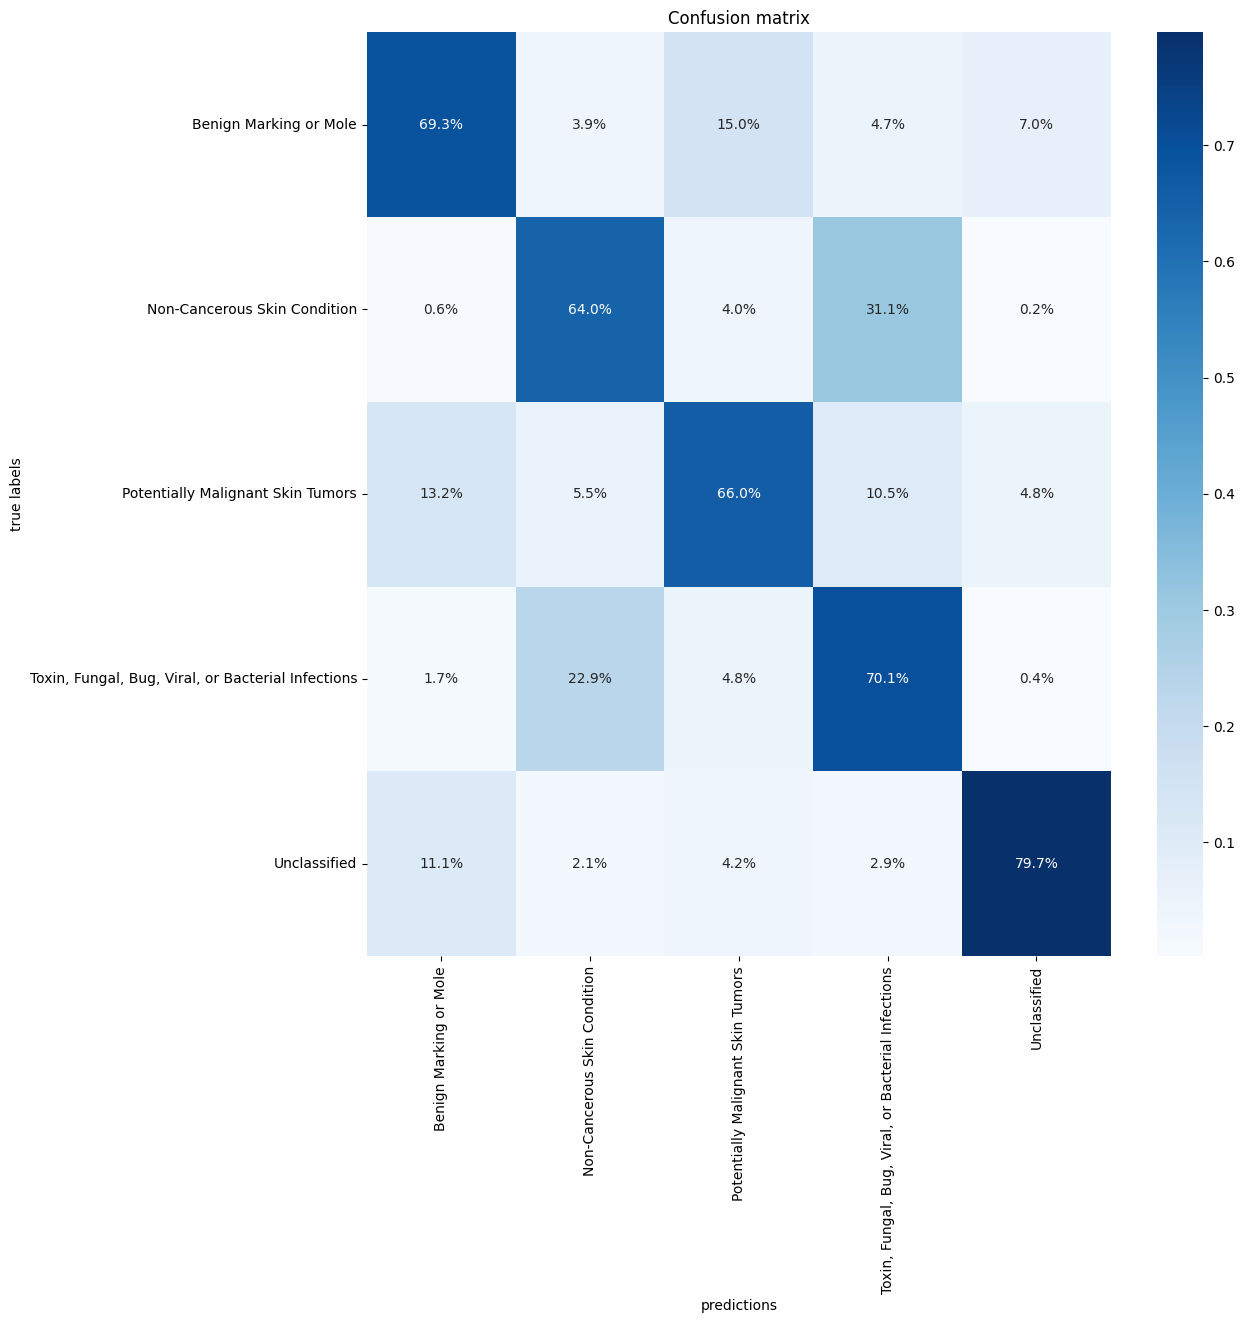

In [23]:
true_labels, predictions = test_model(model, dataloader_test, normalize=True)
c_matrix = confusion_matrix(true_labels, predictions, normalize='true')
plt.figure(figsize=(12, 12))
plt.title("Confusion matrix")
sns.heatmap(c_matrix, cmap='Blues', annot=True, xticklabels=classes, yticklabels=classes, fmt='.1%', cbar=True)
plt.xlabel('predictions')
plt.ylabel('true labels')
plt.show()

In [24]:
# # False prediction
# test(model, dataloader_test, 2, 0) #(potentially malignant skin tumors, non-cancerous skin condition)

In [25]:
# # Correct prediction of autoimmune disorder
# test(model, dataloader_test, 3, 3)

In [26]:
# # Trace model

# # must be the same size a minibatch with 1 example image
# example = torch.rand(1, 3, 224, 224)

# # move model back to cpu, do tracing, and optimize
# model_conv = model.to('cpu')
# traced_script_module = torch.jit.trace(model_conv, example)
# torchscript_model_optimized = optimize_for_mobile(traced_script_module)

# # save optimized model for mobile
# PATH = f'model/{model_name}_traced.pt'
# torchscript_model_optimized.save(PATH)

# Conversion from PyTorch to CoreML
https://github.com/vincentfpgarcia/from-pytorch-to-coreml/blob/master/step6_part1.md

In [27]:
pwd

'/home/ec2-user/SageMaker/teledermatologyAI_capstone'

In [28]:
classes

['Benign Marking or Mole',
 'Non-Cancerous Skin Condition',
 'Potentially Malignant Skin Tumors',
 'Toxin, Fungal, Bug, Viral, or Bacterial Infections',
 'Unclassified']

In [29]:
# model_name = 'resnet_10e_SGD_GS9'
# !aws s3 cp s3://rubyhan-w210-datasets/model/"$model_name".pt model/"$model_name".pt

In [30]:
import coremltools as ct
from coremltools.converters import ClassifierConfig

classifier_config = ClassifierConfig(class_labels=classes)
model = torch.load(f'model/{model_name}.pt', map_location=torch.device('cpu'))

# Create dummy input
dummy_input = torch.rand(1, 3, 224, 224)

model_conv = model.to('cpu')

# Trace the model
traced_model = torch.jit.trace(model_conv, dummy_input)

# Create the input image type
input_image = ct.ImageType(name="my_input", shape=(1, 3, 224, 224), scale=1/255)

# Convert the model
coreml_model = ct.convert(traced_model, inputs=[input_image], classifier_config=classifier_config)

# Modify the output's name to "my_output" in the spec
spec = coreml_model.get_spec()
ct.utils.rename_feature(spec, "840", "my_output") #var_840

# Re-create the model from the updated spec
coreml_model_updated = ct.models.MLModel(spec)

# Save the CoreML model
coremlmodel_name = model_name
coreml_model_updated.save(f'model/{coremlmodel_name}.mlmodel')

# Load the CoreML model
model =  ct.models.MLModel(f'model/{coremlmodel_name}.mlmodel')

# Display its specifications
print()
print(model)

from PIL import Image

# Load the test image
# image = Image.open('inference/Potentially Malignant Skin Tumors/melanoma.jpeg')

# # Prediction vector as a numpy array
# pred = model.predict({'my_input': image.resize((224, 224))})
# pred = pred['my_output']
# pred = pred.squeeze()

# # Display the most probable class
# idx = pred.argmax()
# print('Predicted class : %d (%s)' % (idx, classes[idx]))
# pred['classLabel']

Running MIL Common passes:   0%|          | 0/38 [00:00<?, ? passes/s]/home/ec2-user/SageMaker/teledermatologyAI_capstone/w210_env/lib/python3.8/site-packages/coremltools/converters/mil/mil/passes/name_sanitization_utils.py:129: UserWarning: Output, '840', of the source model, has been renamed to 'var_840' in the Core ML model.
  warnings.warn(msg.format(var.name, new_name))
Translating MIL ==> NeuralNetwork Ops: 100%|██████████| 455/455 [00:02<00:00, 180.45 ops/s] 



input {
  name: "my_input"
  type {
    imageType {
      width: 224
      height: 224
      colorSpace: RGB
    }
  }
}
output {
  name: "var_840"
  type {
    dictionaryType {
      stringKeyType {
      }
    }
  }
}
output {
  name: "classLabel"
  type {
    stringType {
    }
  }
}
predictedFeatureName: "classLabel"
predictedProbabilitiesName: "var_840"
metadata {
  userDefined {
    key: "com.github.apple.coremltools.source"
    value: "torch==1.13.0+cu117"
  }
  userDefined {
    key: "com.github.apple.coremltools.version"
    value: "6.0"
  }
}



# Inference

In [31]:
inference_dataset = ImageFolder(root = 'inference/', transform=transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std)
]))

dataloader_inference = DataLoader(inference_dataset, batch_size=1, 
                                  shuffle=False, num_workers=1, drop_last=False)

def inference_model(model, dl, normalize=True):
    model.eval()
    true_labels = []
    predictions = []
    total = 0
    num_correct = 0
    # device = torch.device('cpu')
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    with torch.no_grad():
        for images, labels in dl:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predicted = torch.argmax(outputs.data,-1)        
            true_labels.append(labels.cpu().numpy())
            predictions.append(predicted.cpu().numpy())
            total += labels.size(0)
            num_correct += (predicted == labels).sum()
        print(f'Inference Accuracy of the model: {float(num_correct)/float(total)*100:.2f}')    
        true_labels = np.hstack(true_labels)
        predictions = np.hstack(predictions)

    return true_labels, predictions

In [32]:
# model = torch.jit.load(f'model/{model_name}_traced.pt')
model = torch.load(f'model/{model_name}.pt')
display(model_name)
true_labels, predictions = inference_model(model, dataloader_inference, normalize=True)

'split_8_resnet_10e_AdamW_lr0_00056'

Inference Accuracy of the model: 20.00


In [33]:
classes

['Benign Marking or Mole',
 'Non-Cancerous Skin Condition',
 'Potentially Malignant Skin Tumors',
 'Toxin, Fungal, Bug, Viral, or Bacterial Infections',
 'Unclassified']

In [34]:
true_labels

array([0, 1, 2, 3, 4])

In [35]:
predictions

array([0, 2, 0, 2, 2])

In [36]:
# !tar -czf model/model.tar.gz model/merged_resnet50.pt

In [37]:
!aws s3 cp model/"$model_name".mlmodel s3://rubyhan-w210-datasets/model/

upload: model/split_8_resnet_10e_AdamW_lr0_00056.mlmodel to s3://rubyhan-w210-datasets/model/split_8_resnet_10e_AdamW_lr0_00056.mlmodel
